FAST mode: 25% random sampling within each unique (Vbus…Ls11) combination

Optional shared-combo filtering so you only keep combos that appear in all MOSFET devices

70/15/15 split for train / validation / test

Per-target and average R², RMSE, MAE

Sorted line plot for any chosen target

[INFO] FAST sample: 86335 rows (from 431675)

=== Validation Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9706 6.8951e-10 3.3858e-10
voltage_rise_time_pulse2 0.8798 1.5324e-09 7.5896e-10
voltage_fall_time_pulse1 0.9989 2.2936e-10 1.4896e-10
voltage_fall_time_pulse2 0.9989 2.2814e-10 1.4807e-10
current_rise_time_pulse1 0.9138 1.3787e-08 7.0670e-09
current_rise_time_pulse2 0.8949 8.6563e-09 4.1831e-09
current_fall_time_pulse1 0.9893 1.3397e-09 7.7236e-10
current_fall_time_pulse2 0.9895 1.3231e-09 7.6181e-10
       overshoot_pulse_1 0.9718 2.2704e+00 1.6829e+00
       overshoot_pulse_2 0.9318 6.9451e+00 5.2804e+00
      undershoot_pulse_1 0.9682 2.3977e+00 1.6786e+00
      undershoot_pulse_2 0.9687 2.3794e+00 1.6730e+00
   ringing_frequency_MHz 0.9980 1.4378e+00 1.0356e+00
R2_avg          0.9595
RMSE_avg    2.2680e+00
MAE_avg     8.7311e-01
dtype: object
Train Time (s): 27.1689
Predict Time (ms/sample): 0.0216


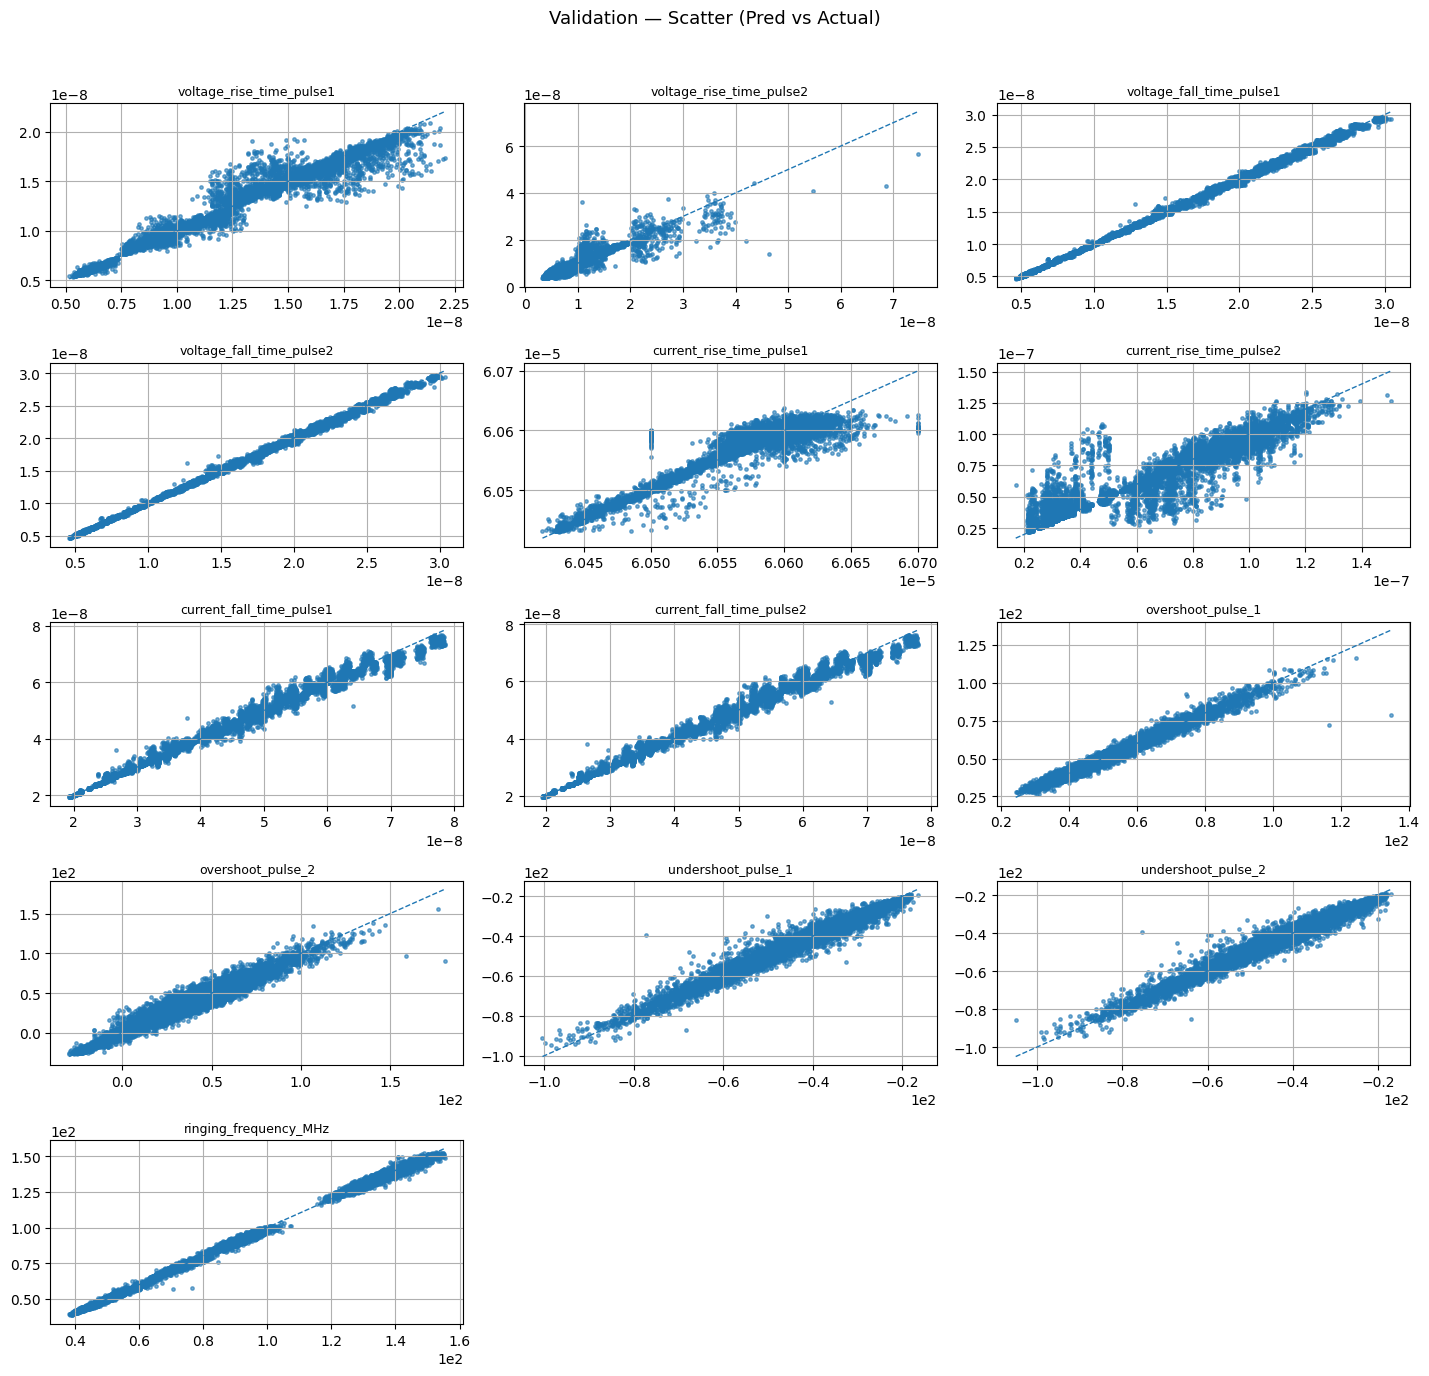


=== Test Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9720 6.7474e-10 3.4137e-10
voltage_rise_time_pulse2 0.8760 1.5837e-09 7.6508e-10
voltage_fall_time_pulse1 0.9989 2.2398e-10 1.4680e-10
voltage_fall_time_pulse2 0.9989 2.2563e-10 1.4688e-10
current_rise_time_pulse1 0.9227 1.3065e-08 6.8362e-09
current_rise_time_pulse2 0.9021 8.3538e-09 4.0904e-09
current_fall_time_pulse1 0.9894 1.3182e-09 7.5505e-10
current_fall_time_pulse2 0.9896 1.3050e-09 7.4620e-10
       overshoot_pulse_1 0.9709 2.3182e+00 1.7102e+00
       overshoot_pulse_2 0.9352 6.8214e+00 5.1707e+00
      undershoot_pulse_1 0.9674 2.4377e+00 1.7038e+00
      undershoot_pulse_2 0.9684 2.4012e+00 1.6985e+00
   ringing_frequency_MHz 0.9980 1.4555e+00 1.0507e+00
R2_avg          0.9607
RMSE_avg    2.2486e+00
MAE_avg     8.7184e-01
dtype: object
Predict Time (ms/sample): 0.0221


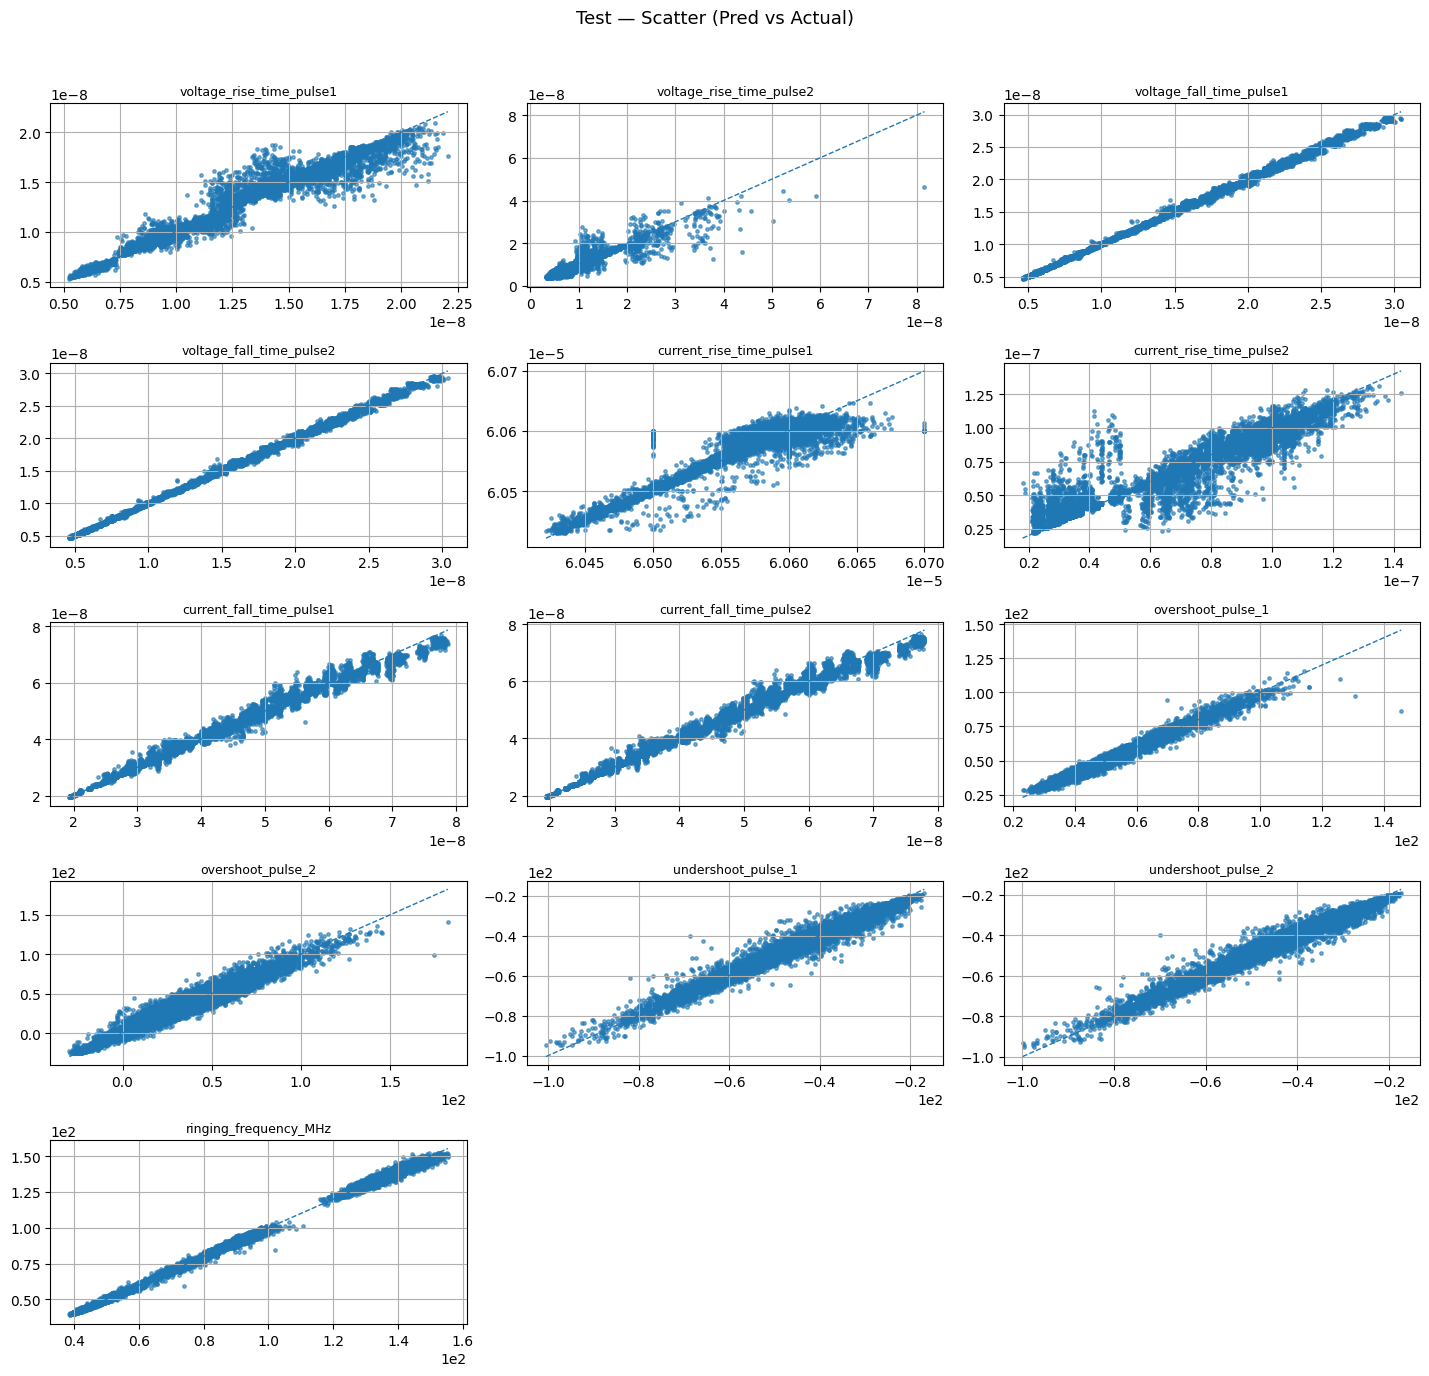

In [16]:
# rf_baseline_scatter_only.py
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===================== Config =====================
TRAIN_FILE = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Train_5_MOSFETs.csv"   # <-- your seen MOSFET dataset
RANDOM_STATE = 42
FAST_FRAC = 0.25          # 25% sample per (Vbus..Ls11) combo
GRID_COLS = 3             # columns in the scatter grid
# ==================================================

TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]

# ---------- helpers ----------
def encode_part_number(df):
    if "Part_Number" in df.columns:
        le = LabelEncoder()
        df["Part_Number"] = le.fit_transform(df["Part_Number"].astype(str))
    return df

def sample_by_combo(df, combo_cols, frac=0.25, random_state=42):
    """Sample a fraction within each unique combo (no groupby.apply)."""
    rng = np.random.default_rng(random_state)
    parts = []
    for _, g in df.groupby(combo_cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    out = pd.concat(parts, axis=0).sort_index().reset_index(drop=True)
    return out

def split_70_15_15(X, y, seed=RANDOM_STATE):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=seed, shuffle=True
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=seed, shuffle=True
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_rf(X_train, y_train, seed=RANDOM_STATE):
    model = RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=seed
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    return model, train_time

def predict_with_timing(model, X):
    t0 = time.time()
    y_pred = model.predict(X)
    ms_per_sample = (time.time() - t0) / len(X) * 1000.0
    return y_pred, ms_per_sample

def compute_metrics(y_true, y_pred):
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae = mean_absolute_error(yt, yp)
        rows.append([t, r2, rmse, mae])
    df = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg": r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg": mean_absolute_error(y_true, y_pred),
    }
    return df, overall

def format_metrics(df_metrics, overall):
    df_fmt = df_metrics.copy()
    df_fmt["R2"]   = df_fmt["R2"].map(lambda x: f"{x:.4f}")    # 4 decimals
    df_fmt["RMSE"] = df_fmt["RMSE"].map(lambda x: f"{x:.4e}")  # scientific
    df_fmt["MAE"]  = df_fmt["MAE"].map(lambda x: f"{x:.4e}")   # scientific
    overall_fmt = {
        "R2_avg":  f"{overall['R2_avg']:.4f}",
        "RMSE_avg":f"{overall['RMSE_avg']:.4e}",
        "MAE_avg": f"{overall['MAE_avg']:.4e}",
    }
    return df_fmt, overall_fmt

def scatter_grid(y_true, y_pred, target_names, title, n_cols=3):
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 2.8*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=6, alpha=0.6)
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1)  # 45° line
        ax.set_title(t, fontsize=9)
        ax.grid(True)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ----------------- main -----------------
def main():
    # Load & prep (seen data only)
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = encode_part_number(df)

    # 25% per (Vbus..Ls11) combo
    df_fast = sample_by_combo(df, COMBO_COLS, frac=FAST_FRAC, random_state=RANDOM_STATE)
    print(f"[INFO] FAST sample: {len(df_fast)} rows (from {len(df)})")

    # Build X, y
    feature_cols = [c for c in df_fast.columns if c not in TARGETS]
    X = df_fast[feature_cols].values
    y = df_fast[TARGETS].values

    # 70/15/15 split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X, y)

    # Train RF + timings
    model, train_time = train_rf(X_tr, y_tr)

    # Validation
    y_va_pred, va_ms = predict_with_timing(model, X_va)
    va_metrics, va_overall = compute_metrics(y_va, y_va_pred)
    va_metrics_fmt, va_overall_fmt = format_metrics(va_metrics, va_overall)

    print("\n=== Validation Set ===")
    print(va_metrics_fmt.to_string(index=False))
    print(pd.Series(va_overall_fmt))
    print(f"Train Time (s): {train_time:.4f}")
    print(f"Predict Time (ms/sample): {va_ms:.4f}")

    scatter_grid(y_va, y_va_pred, TARGETS, title="Validation — Scatter (Pred vs Actual)", n_cols=GRID_COLS)

    # Test
    y_te_pred, te_ms = predict_with_timing(model, X_te)
    te_metrics, te_overall = compute_metrics(y_te, y_te_pred)
    te_metrics_fmt, te_overall_fmt = format_metrics(te_metrics, te_overall)

    print("\n=== Test Set ===")
    print(te_metrics_fmt.to_string(index=False))
    print(pd.Series(te_overall_fmt))
    print(f"Predict Time (ms/sample): {te_ms:.4f}")

    scatter_grid(y_te, y_te_pred, TARGETS, title="Test — Scatter (Pred vs Actual)", n_cols=GRID_COLS)

if __name__ == "__main__":
    main()


With Noise induced 

[INFO] FAST sample: 86335 rows (from 431675)
[INFO] After noise augmentation: 129503 rows


C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1203.34481645 1195.43789931  986.81789025 ...  995.3048545  1007.20000589
  794.60034127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise
C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1200. 1200. 1200. ... 1200. 1200. 1200.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise
C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[62.77275273 25


=== Validation Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9745 6.4092e-10 3.2415e-10
voltage_rise_time_pulse2 0.8950 1.4458e-09 7.1315e-10
voltage_fall_time_pulse1 0.9989 2.2832e-10 1.4587e-10
voltage_fall_time_pulse2 0.9989 2.2816e-10 1.4597e-10
current_rise_time_pulse1 0.9299 1.2471e-08 6.4158e-09
current_rise_time_pulse2 0.9111 7.9416e-09 3.8888e-09
current_fall_time_pulse1 0.9893 1.3247e-09 7.7006e-10
current_fall_time_pulse2 0.9895 1.3104e-09 7.5922e-10
       overshoot_pulse_1 0.9753 2.1217e+00 1.5878e+00
       overshoot_pulse_2 0.9100 8.1016e+00 6.0675e+00
      undershoot_pulse_1 0.9731 2.2229e+00 1.5736e+00
      undershoot_pulse_2 0.9733 2.2126e+00 1.5606e+00
   ringing_frequency_MHz 0.9982 1.3430e+00 9.6615e-01
R2_avg          0.9628
RMSE_avg    2.5081e+00
MAE_avg     9.0428e-01
dtype: object
Train Time (s): 98.9509
Predict Time (ms/sample): 0.0193


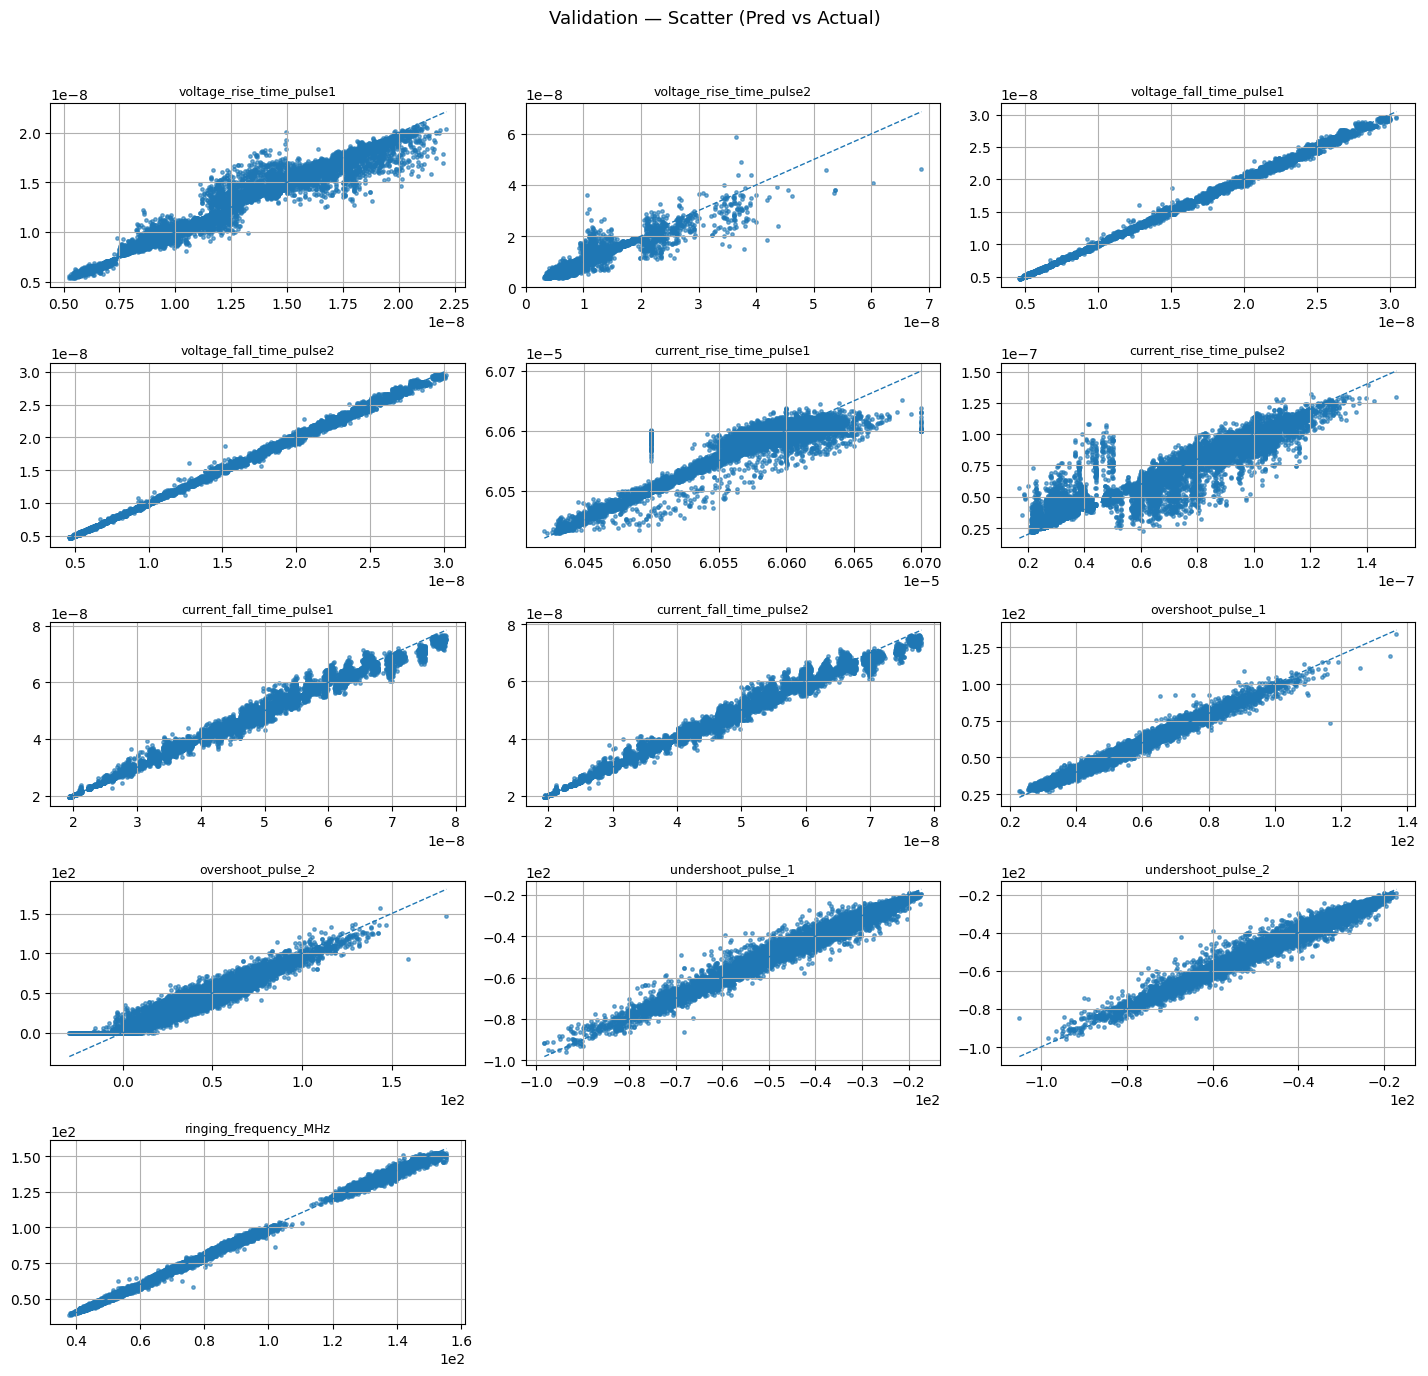


=== Test Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9759 6.2352e-10 3.1356e-10
voltage_rise_time_pulse2 0.9028 1.3899e-09 7.0874e-10
voltage_fall_time_pulse1 0.9989 2.2868e-10 1.4739e-10
voltage_fall_time_pulse2 0.9989 2.2845e-10 1.4692e-10
current_rise_time_pulse1 0.9281 1.2748e-08 6.5678e-09
current_rise_time_pulse2 0.9062 8.1344e-09 3.9627e-09
current_fall_time_pulse1 0.9890 1.3554e-09 7.8605e-10
current_fall_time_pulse2 0.9892 1.3401e-09 7.7682e-10
       overshoot_pulse_1 0.9766 2.0666e+00 1.5779e+00
       overshoot_pulse_2 0.9090 8.0756e+00 6.0406e+00
      undershoot_pulse_1 0.9726 2.2221e+00 1.5655e+00
      undershoot_pulse_2 0.9732 2.1962e+00 1.5591e+00
   ringing_frequency_MHz 0.9983 1.3486e+00 9.6867e-01
R2_avg          0.9630
RMSE_avg    2.4972e+00
MAE_avg     9.0091e-01
dtype: object
Predict Time (ms/sample): 0.0185


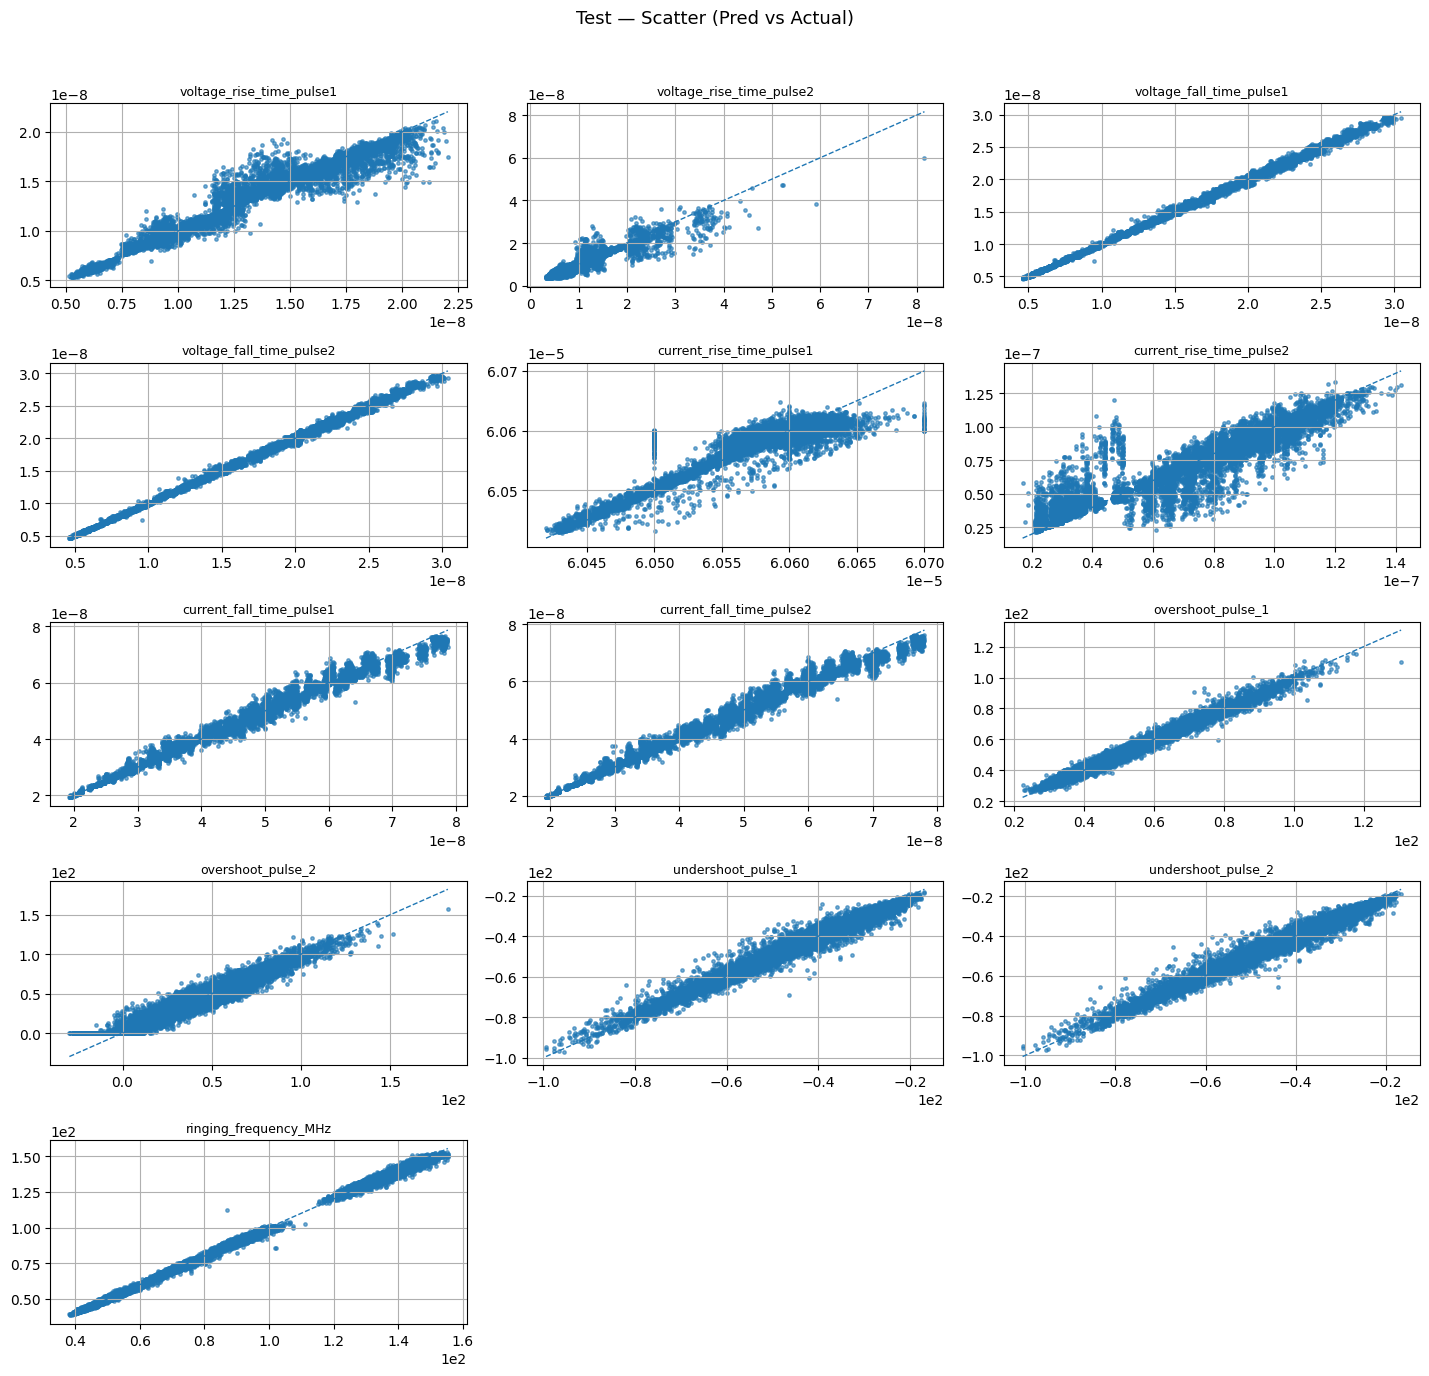

In [18]:
# rf_baseline_noise_scatter.py
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ===================== Config =====================
TRAIN_FILE = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Train_5_MOSFETs.csv"   # <-- your seen MOSFET dataset

RANDOM_STATE = 42

# FAST sampling per (Vbus..Ls11) combo
FAST_FRAC = 0.25

# Noise augmentation (on training dataframe before split)
USE_NOISE_AUG = True
NOISE_STD_PCT = 0.03   # 3% of each feature's std
NOISE_FRAC = 0.50      # add +50% rows of noisy copies

# Plot grid layout
GRID_COLS = 3
# ==================================================

TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]

# Targets that should never be negative (undershoot_* are intentionally excluded)
POSITIVE_ONLY_TARGETS = {
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'ringing_frequency_MHz'
}

# ---------- helpers ----------
def encode_part_number(df):
    if "Part_Number" in df.columns:
        le = LabelEncoder()
        df["Part_Number"] = le.fit_transform(df["Part_Number"].astype(str))
    return df

def sample_by_combo(df, combo_cols, frac=0.25, random_state=42):
    """Sample a fraction within each unique combo (no groupby.apply -> no deprecation warnings)."""
    rng = np.random.default_rng(random_state)
    parts = []
    for _, g in df.groupby(combo_cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    out = pd.concat(parts, axis=0).sort_index().reset_index(drop=True)
    return out

def split_70_15_15(X, y, seed=RANDOM_STATE):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=seed, shuffle=True
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=seed, shuffle=True
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_rf(X_train, y_train, seed=RANDOM_STATE):
    model = RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=seed
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    return model, train_time

def predict_with_timing(model, X):
    t0 = time.time()
    y_pred = model.predict(X)
    ms_per_sample = (time.time() - t0) / len(X) * 1000.0
    return y_pred, ms_per_sample

def compute_metrics(y_true, y_pred):
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        r2 = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        mae = mean_absolute_error(yt, yp)
        rows.append([t, r2, rmse, mae])
    df = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg": r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg": mean_absolute_error(y_true, y_pred),
    }
    return df, overall

def format_metrics(df_metrics, overall):
    df_fmt = df_metrics.copy()
    df_fmt["R2"]   = df_fmt["R2"].map(lambda x: f"{x:.4f}")    # 4 decimals
    df_fmt["RMSE"] = df_fmt["RMSE"].map(lambda x: f"{x:.4e}")  # scientific
    df_fmt["MAE"]  = df_fmt["MAE"].map(lambda x: f"{x:.4e}")   # scientific
    overall_fmt = {
        "R2_avg":  f"{overall['R2_avg']:.4f}",
        "RMSE_avg":f"{overall['RMSE_avg']:.4e}",
        "MAE_avg": f"{overall['MAE_avg']:.4e}",
    }
    return df_fmt, overall_fmt

def scatter_grid(y_true, y_pred, target_names, title, n_cols=3):
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 2.8*n_rows))
    axes = axes.flatten()

    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=6, alpha=0.6)
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1)  # 45° line
        ax.set_title(t, fontsize=9)
        ax.grid(True)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------- noise augmentation & clipping ----------
def augment_with_noise(df, feature_cols, std_pct=0.03, frac=0.5, seed=42, exclude_cols=None):
    """
    Add a noisy copy of ~frac*len(df) rows. Gaussian noise per feature:
    N(0, std_pct * feature_std). Excludes columns in exclude_cols.
    """
    exclude_cols = set(exclude_cols or [])
    noise_cols = [c for c in feature_cols if c not in exclude_cols]
    if not noise_cols:
        return df

    rng = np.random.default_rng(seed)
    n_extra = max(1, int(round(frac * len(df))))
    idx = rng.choice(df.index.to_numpy(), size=n_extra, replace=True)
    aug = df.loc[idx].copy()

    col_std = df[noise_cols].std(ddof=0).replace(0.0, 1e-12)
    noise = rng.normal(loc=0.0, scale=(col_std.values * std_pct),
                       size=(len(aug), len(noise_cols)))
    aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise

    return pd.concat([df, aug], axis=0).reset_index(drop=True)

def clip_positive_targets(y_pred, target_names):
    y = y_pred.copy()
    for i, t in enumerate(target_names):
        if t in POSITIVE_ONLY_TARGETS:
            y[:, i] = np.maximum(y[:, i], 0.0)
    return y
# -----------------------------------------------

def main():
    # Load & prep (seen data)
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = encode_part_number(df)

    # 25% per (Vbus..Ls11) combo
    df_fast = sample_by_combo(df, COMBO_COLS, frac=FAST_FRAC, random_state=RANDOM_STATE)
    print(f"[INFO] FAST sample: {len(df_fast)} rows (from {len(df)})")

    # Feature list (exclude targets)
    feature_cols = [c for c in df_fast.columns if c not in TARGETS]

    # Optional: noise augmentation (do NOT perturb Part_Number)
    if USE_NOISE_AUG:
        df_fast = augment_with_noise(
            df_fast,
            feature_cols=feature_cols,
            std_pct=NOISE_STD_PCT,
            frac=NOISE_FRAC,
            seed=RANDOM_STATE,
            exclude_cols=["Part_Number"]
        )
        print(f"[INFO] After noise augmentation: {len(df_fast)} rows")

    # Build arrays
    X = df_fast[feature_cols].values
    y = df_fast[TARGETS].values

    # 70/15/15 split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X, y)

    # Train RF + timings
    model, train_time = train_rf(X_tr, y_tr)

    # ---- Validation ----
    y_va_pred, va_ms = predict_with_timing(model, X_va)
    y_va_pred = clip_positive_targets(y_va_pred, TARGETS)

    va_metrics, va_overall = compute_metrics(y_va, y_va_pred)
    va_metrics_fmt, va_overall_fmt = format_metrics(va_metrics, va_overall)

    print("\n=== Validation Set ===")
    print(va_metrics_fmt.to_string(index=False))
    print(pd.Series(va_overall_fmt))
    print(f"Train Time (s): {train_time:.4f}")
    print(f"Predict Time (ms/sample): {va_ms:.4f}")

    scatter_grid(y_va, y_va_pred, TARGETS,
                 title="Validation — Scatter (Pred vs Actual)",
                 n_cols=GRID_COLS)

    # ---- Test ----
    y_te_pred, te_ms = predict_with_timing(model, X_te)
    y_te_pred = clip_positive_targets(y_te_pred, TARGETS)

    te_metrics, te_overall = compute_metrics(y_te, y_te_pred)
    te_metrics_fmt, te_overall_fmt = format_metrics(te_metrics, te_overall)

    print("\n=== Test Set ===")
    print(te_metrics_fmt.to_string(index=False))
    print(pd.Series(te_overall_fmt))
    print(f"Predict Time (ms/sample): {te_ms:.4f}")

    scatter_grid(y_te, y_te_pred, TARGETS,
                 title="Test — Scatter (Pred vs Actual)",
                 n_cols=GRID_COLS)

if __name__ == "__main__":
    main()


UNSEEN MOSFET OPTIONAL

[INFO] FAST sample: 86335 rows (from 431675)
[INFO] After noise augmentation: 129503 rows


C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1203.34481645 1195.43789931  986.81789025 ...  995.3048545  1007.20000589
  794.60034127]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise
C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1200. 1200. 1200. ... 1200. 1200. 1200.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise
C:\Users\pc\AppData\Local\Temp\ipykernel_31800\4097761264.py:166: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[62.77275273 25


=== Validation Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9745 6.4092e-10 3.2415e-10
voltage_rise_time_pulse2 0.8950 1.4458e-09 7.1315e-10
voltage_fall_time_pulse1 0.9989 2.2832e-10 1.4587e-10
voltage_fall_time_pulse2 0.9989 2.2816e-10 1.4597e-10
current_rise_time_pulse1 0.9299 1.2471e-08 6.4158e-09
current_rise_time_pulse2 0.9111 7.9416e-09 3.8888e-09
current_fall_time_pulse1 0.9893 1.3247e-09 7.7006e-10
current_fall_time_pulse2 0.9895 1.3104e-09 7.5922e-10
       overshoot_pulse_1 0.9753 2.1217e+00 1.5878e+00
       overshoot_pulse_2 0.9100 8.1016e+00 6.0675e+00
      undershoot_pulse_1 0.9731 2.2229e+00 1.5736e+00
      undershoot_pulse_2 0.9733 2.2126e+00 1.5606e+00
   ringing_frequency_MHz 0.9982 1.3430e+00 9.6615e-01
R2_avg          0.9628
RMSE_avg    2.5081e+00
MAE_avg     9.0428e-01
dtype: object
Train Time (s): 131.6534
Predict Time (ms/sample): 0.0618


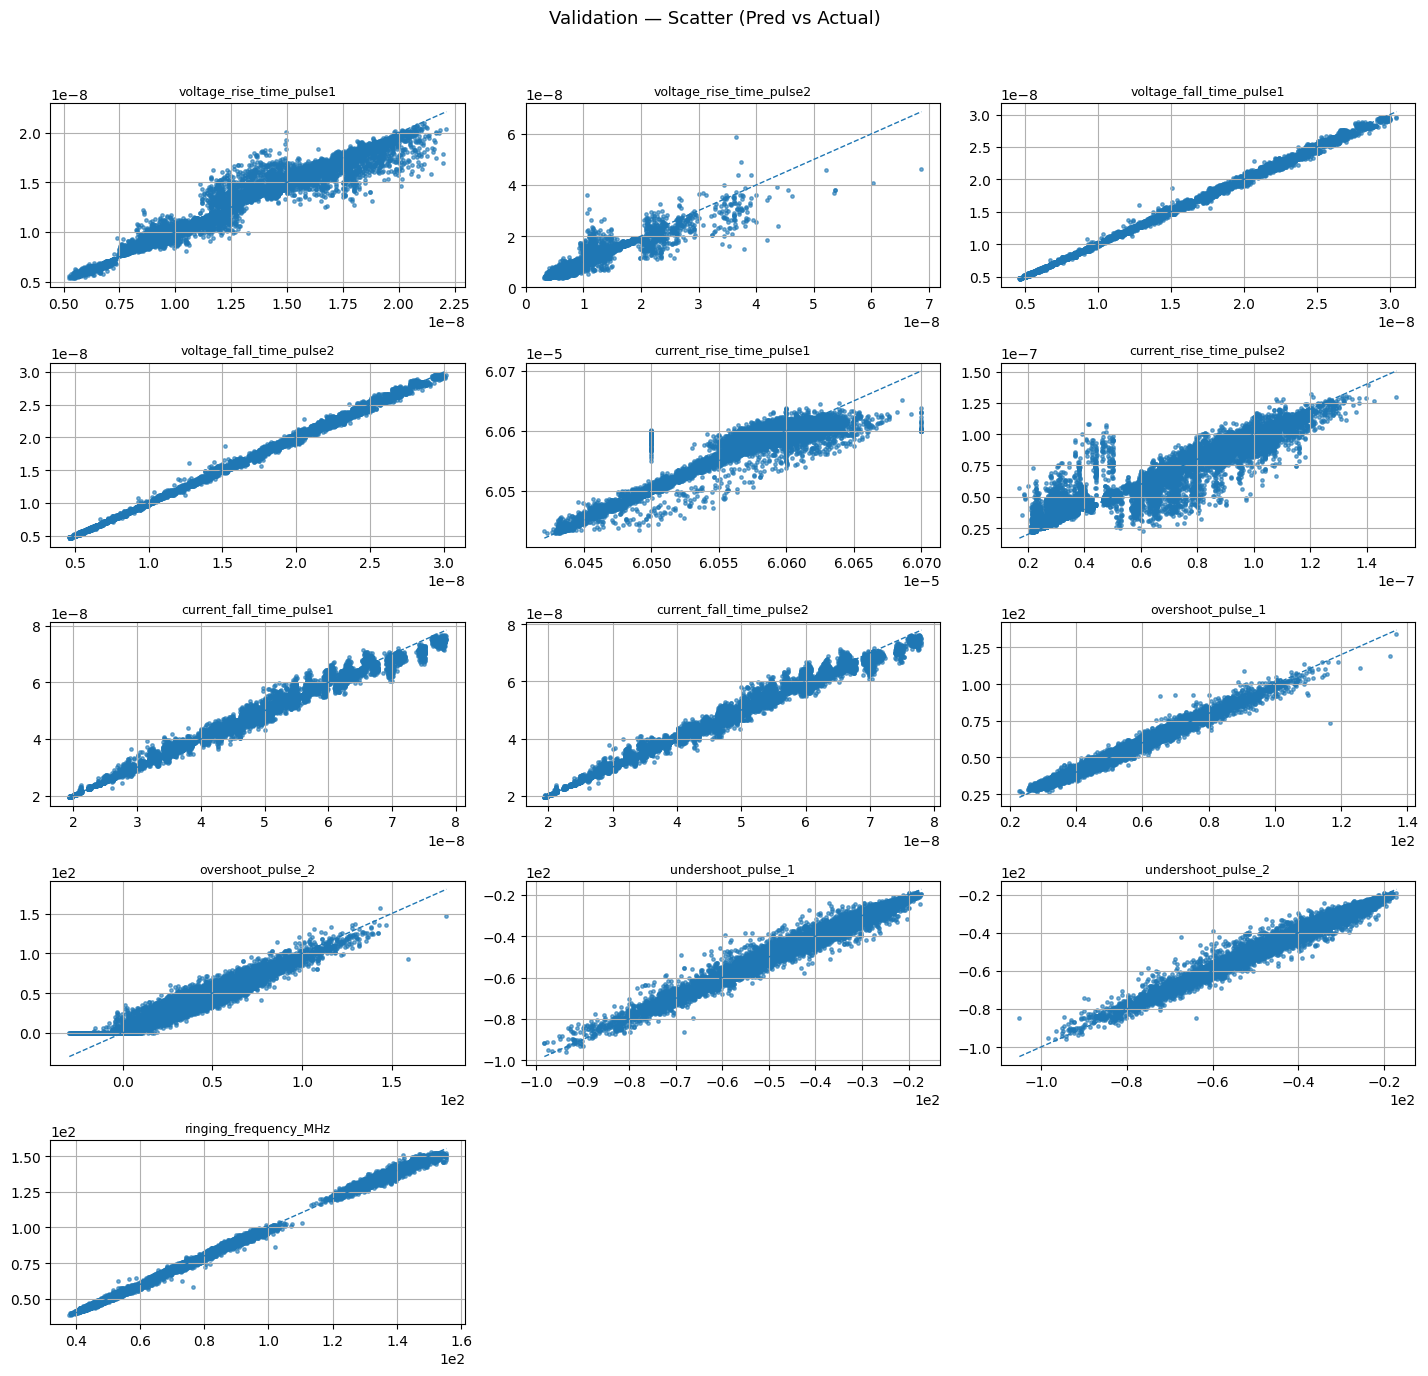


=== Test Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9759 6.2352e-10 3.1356e-10
voltage_rise_time_pulse2 0.9028 1.3899e-09 7.0874e-10
voltage_fall_time_pulse1 0.9989 2.2868e-10 1.4739e-10
voltage_fall_time_pulse2 0.9989 2.2845e-10 1.4692e-10
current_rise_time_pulse1 0.9281 1.2748e-08 6.5678e-09
current_rise_time_pulse2 0.9062 8.1344e-09 3.9627e-09
current_fall_time_pulse1 0.9890 1.3554e-09 7.8605e-10
current_fall_time_pulse2 0.9892 1.3401e-09 7.7682e-10
       overshoot_pulse_1 0.9766 2.0666e+00 1.5779e+00
       overshoot_pulse_2 0.9090 8.0756e+00 6.0406e+00
      undershoot_pulse_1 0.9726 2.2221e+00 1.5655e+00
      undershoot_pulse_2 0.9732 2.1962e+00 1.5591e+00
   ringing_frequency_MHz 0.9983 1.3486e+00 9.6867e-01
R2_avg          0.9630
RMSE_avg    2.4972e+00
MAE_avg     9.0091e-01
dtype: object
Predict Time (ms/sample): 0.0350


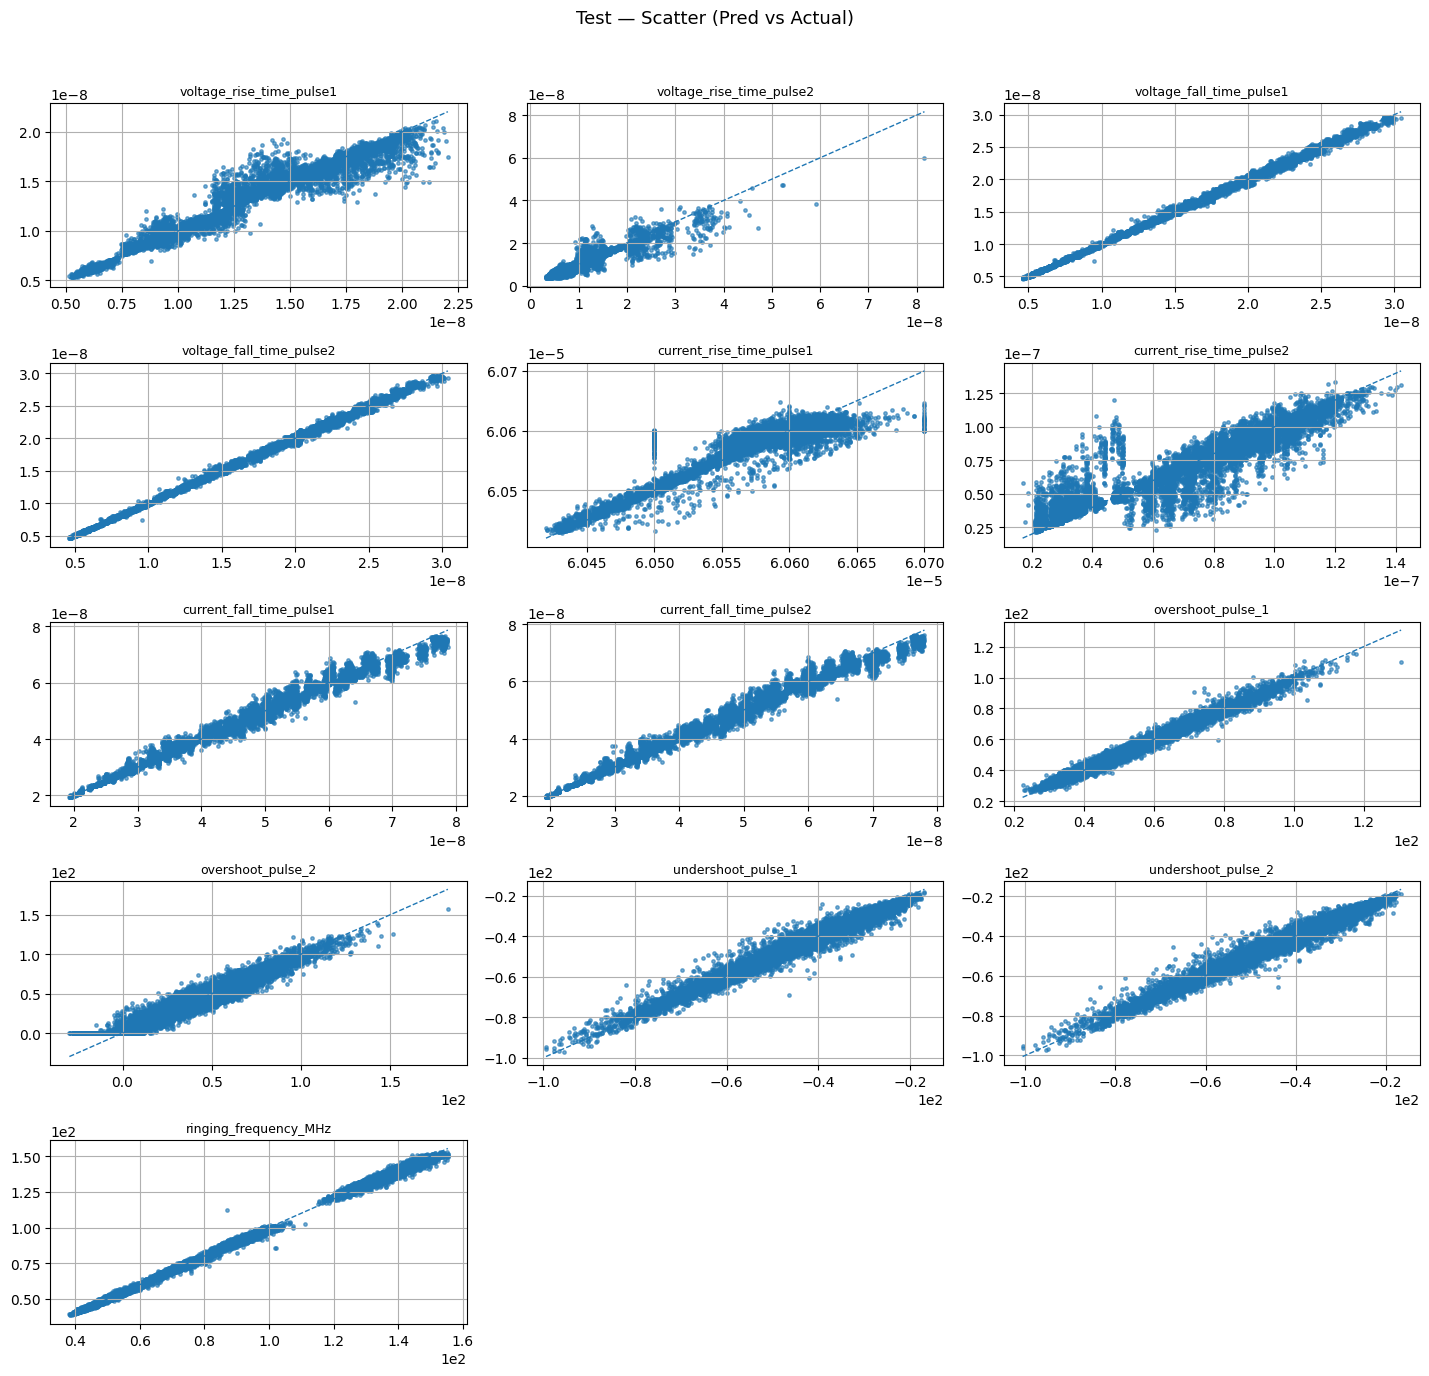

NameError: name 'model' is not defined

In [21]:
# ===================== Unseen MOSFET Testing =====================
UNSEEN_FILE = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Test_1_MOSFET.csv"  # unseen MOSFET dataset

def test_unseen(model, df_train, df_unseen):
    # Encode Part_Number in unseen using the mapping from training
    if "Part_Number" in df_train.columns and "Part_Number" in df_unseen.columns:
        le = LabelEncoder()
        le.fit(df_train["Part_Number"].astype(str))
        df_unseen["Part_Number"] = le.transform(df_unseen["Part_Number"].astype(str))

    # Keep only matching (Vbus..Ls11) combos between train & unseen
    train_combos = df_train[COMBO_COLS].drop_duplicates()
    merged = df_unseen.merge(train_combos, on=COMBO_COLS, how="inner")
    print(f"[INFO] Unseen filtered to {len(merged)} rows from {len(df_unseen)}")

    # Features and targets
    feature_cols = [c for c in merged.columns if c not in TARGETS]
    X_unseen = merged[feature_cols].values
    y_unseen = merged[TARGETS].values

    # Predict
    y_unseen_pred, unseen_ms = predict_with_timing(model, X_unseen)
    y_unseen_pred = clip_positive_targets(y_unseen_pred, TARGETS)

    # Metrics
    unseen_metrics, unseen_overall = compute_metrics(y_unseen, y_unseen_pred)
    unseen_metrics_fmt, unseen_overall_fmt = format_metrics(unseen_metrics, unseen_overall)

    print("\n=== Unseen MOSFET Set ===")
    print(unseen_metrics_fmt.to_string(index=False))
    print(pd.Series(unseen_overall_fmt))
    print(f"Predict Time (ms/sample): {unseen_ms:.4f}")

    scatter_grid(y_unseen, y_unseen_pred, TARGETS,
                 title="Unseen MOSFET — Scatter (Pred vs Actual)",
                 n_cols=GRID_COLS)

# Example usage at the end of main():
if __name__ == "__main__":
    # Your original training pipeline
    main()

    # Load train & unseen data for testing
    df_train_full = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df_train_full = encode_part_number(df_train_full)
    df_unseen_full = pd.read_csv(UNSEEN_FILE).dropna().reset_index(drop=True)

    # Call unseen testing
    test_unseen(model, df_train_full, df_unseen_full)
